# Swash Timestack Tracer
This notebook is used to train a regression convolutional network to find the position of the swash front in the middle row of pixels of a snapshot from a timestack. The network structure used is sequential in this code.

# Your Task:
Train the best convolutional neural network for tracing the swash front. The default structure used is a lightweight network which you can build from. This starting point network is complex enough to converge but struggles with a lot of the edge cases.

Code cell 1 imports all the libraries and stores a function used for evaluating your trained model. You don't need to change anything in this code cell.

Code cell 2 loads the training images into the notebook and adds any data augmentation. 

In [7]:
# code is modified from a tutorial from sentdex youtube - check out his content, it is really good!

# import libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import shutil
import random
import csv

# function used to evaluate how good the model is
def compare_shoreline(min_uprush, max_uprush, tf_model_version, IMG_SIZE, timestack_name, results_dir):
    
    folder_name = "test_timestacks/"

    image_range = max_uprush - min_uprush
    
    timestack = cv2.imread(folder_name + timestack_name)
    timestack_focus = timestack[:, min_uprush:max_uprush]
    timestack_labelled = cv2.imread(folder_name + timestack_name + "_output.png")
    timestack_annotated = timestack_labelled.copy()

    height_of_two_peaks = 104 # normally 104 for 2 peaks
    # for every row, find the shoreline location (plot as blue dots). If it is a minimum point plot as red Dot, If maximum plot as blue Dot
    padding = height_of_two_peaks
    height, width, _ = timestack.shape
    width = max_uprush - min_uprush
    timestack_count = 0

    IMG_SIZE_WID = int(IMG_SIZE) # can change this if needed
    tf_images = []
    tf_model_xc = tf.keras.models.load_model(tf_model_version + ".model")

    vertical_coordinates = []
    horizontal_coordinates = []
    for i in range(0, int((height - padding)), 1):

        horizontal_coordinate = i + int(padding/2)

        # get the small section of the image for the horizontal position i
        timestack_snapshot = timestack_focus[i:i + padding, :]
        title_window_2 = "Snapshot of timestack used for processing"

        # classify the timestack snapshot through the convolutional neural network for X_coordinate
        #tf_images = cv2.cvtColor(timestack_snapshot, cv2.COLOR_BGR2GRAY)   # should have this for gray
        tf_images = cv2.resize(timestack_snapshot, (IMG_SIZE_WID, IMG_SIZE))
        tf_images_i = np.array(tf_images)
        tf_images_i = tf.keras.utils.normalize(tf_images_i, axis=1)
        tf_images_i = tf_images_i.reshape(-1, IMG_SIZE, IMG_SIZE_WID, 3)   #should be changed to 1 for gray
        prediction = tf_model_xc.predict([tf_images_i])

        vertical_coordinate = int((prediction[0])*width) + min_uprush

        cv2.circle(timestack_annotated, (vertical_coordinate, horizontal_coordinate), radius=1, color=[255, 0, 0])
        vertical_coordinates.append(vertical_coordinate)
        horizontal_coordinates.append(horizontal_coordinate)

        timestack_count = timestack_count + 1


    # get csv values from labelled timestack
    manual_csv_points_filename = folder_name + "runup_data_test" + timestack_name + ".csv"
    x_vals = []
    t_vals = []
    with open(manual_csv_points_filename, newline='') as csvfile:
        points_reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        initial_row = 5
        initial_row_counter = 0
        for row in points_reader:
            if initial_row_counter > initial_row:
                rows = row[0].split(',')
                x_vals.append( int(rows[0][1:-1]) ) # need to remove [] from value and turn into a number
                t_vals.append( int(rows[1][1:-1]) ) # need to remove [] from value and turn into a number
            initial_row_counter = initial_row_counter + 1

    print("red is hand picked, green is found by model")
    plt.plot(x_vals, t_vals, color = 'r')
    plt.plot(vertical_coordinates, horizontal_coordinates, color = 'g')
    plt.gca().invert_yaxis() # invert axis so it is like the timestack image coordinates
    plt.show()

    #full_stack_window = "timestack_annotated"
    #cv2.namedWindow(full_stack_window, cv2.WINDOW_NORMAL)
    #cv2.resizeWindow(full_stack_window, 1080, 1080)
    #cv2.imshow(full_stack_window, timestack_annotated)
    #cv2.waitKey()
    #cv2.destroyAllWindows()

    # find MSE for evey row
    SE = []
    for i in range(0, len(t_vals), 1):
        # make sure the comparison values line up correctly
        index_matching = np.where(np.array(horizontal_coordinates) == t_vals[i])
        vertical_coordinate_matching = vertical_coordinates[ index_matching[0][0] ]
        # /image range normalises the pixel values between 0 and 1
        SE.append( ((x_vals[i] - vertical_coordinate_matching)/image_range)**2 )
    MSE = np.mean(SE)

    # save the image
    print("saving image")
    cv2.imwrite(results_dir + "/" + "annotated_runup_timestack_" + timestack_name + "_" + tf_model_version + ".png", timestack_annotated)
    
    # save the data
    print("Saving Data to csv file")

    # create csv file
    output_data_name = results_dir + "/" + "runup_data_" + timestack_name + "_" + tf_model_version + ".csv"
    with open(output_data_name, 'w') as writeFile:
        writer = csv.writer(writeFile)
        writer.writerows([["timestack shoreline coordinates"]])

    with open(output_data_name, 'a', newline='') as csvFile:
        writer = csv.writer(csvFile)

        time_row = list(["time (horizontal coordinate)"])
        time_row.extend(horizontal_coordinates)
        x_row = list(["x (vertical coordinate)"])
        x_row.extend(vertical_coordinates)
        writer.writerow(time_row)
        writer.writerow(x_row)

    csvFile.close()

    return MSE

print("done")

done


Now upload all images. This will take a while since there are a lot! If you enable data manipulations it will take even longer. For training lightweight models it is faster just to upload a fraction of the labelled images, so I have set the for loop to get every 10th image. To process all the images, simply set the for loop range step from 10 to 1.

In [2]:
"""%%%%%%%%%%%%%%%%%%%% GET IMAGES %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"""
# Instead get my own images
data = []
IMG_SIZE = 64 # should never be above 256 due to image resolution
IMG_SIZE_WID = IMG_SIZE # can change this if needed, more simple to keep as square
brightness_change = 40 # only necessary if you include data augmentation with brightness variation

# first get all images and label accordingly
image_names = os.listdir("labelled_timestacks")
for i in range(0, len(image_names), 10):
    image_i = cv2.imread("labelled_timestacks/" + image_names[i])

    # get the image size to be normalized
    # we want each snapshot to include approximately 2 swash events, /4 ensures this is the case
    height, _, _ = image_i.shape
    image_i = image_i[int(height/4):int(height - height/4), :, :] 
    
    resized_image = cv2.resize(image_i, (IMG_SIZE_WID, IMG_SIZE))
    Xc = float(image_names[i][23:28]) # this extracts the label of the snapshot, a value from 0 -> 1. 
    data.append([resized_image, Xc])  # x_coordinate (0-1)
    
    # You can add these lines if you want to add data augmentation with brightness variation. 
    # Could be a nice way to simulate sunny and cloudy conditions
    
    # https://stackoverflow.com/questions/37822375/python-opencv-increasing-image-brightness-without-overflowing-uint8-array
    # increase the brightness of image
    #resized_image_bi = resized_image.copy()
    #resized_image_bi = np.where((255 - resized_image_bi) < brightness_change, 255, resized_image_bi + brightness_change)

    # decrease the brightness of image
    #resized_image_bd = resized_image.copy()
    #resized_image_bd = np.where((resized_image_bd) < brightness_change, 0, resized_image_bd - brightness_change)

    #data.append([resized_image_bi, Xc])  # x_coordinate (0-1)
    #data.append([resized_image_bd, Xc])  # x_coordinate (0-1)
    
    # these lines visualize the effect of data augmentation with brightness variation
    #cv2.imshow("test_a", resized_image)
    #cv2.imshow("test_b", resized_image_bi)
    #cv2.imshow("test_c", resized_image_bd)
    #cv2.waitKey()

    # these if statements add duplicates with brightness augmentations of the labelled maximum and minumum 
    # swash regions of each swash event. This is a bit of a hack, but seems to help against bias due to most
    # of the labelled data being near the middle of snapshots.
    if int(image_names[i][29]) == 1:
        brightness_increase = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)
        brightness_increase[...,2] = np.where((255 - brightness_increase[...,2]) < brightness_change, 255, brightness_increase[...,2] + brightness_change)
        brightness_increase = cv2.cvtColor(brightness_increase, cv2.COLOR_HSV2BGR)
        data.append([brightness_increase, Xc])

        brightness_increase2 = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)
        brightness_increase2[...,2] = np.where((255 - brightness_increase2[...,2]) < int(brightness_change/2), 255, brightness_increase2[...,2] + int(brightness_change/2))
        brightness_increase2 = cv2.cvtColor(brightness_increase2, cv2.COLOR_HSV2BGR)
        data.append([brightness_increase2, Xc])

        brightness_decrease = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)
        brightness_decrease[...,2] = np.where((brightness_decrease[...,2]) < brightness_change, 0, brightness_decrease[...,2] - brightness_change)
        brightness_decrease = cv2.cvtColor(brightness_decrease, cv2.COLOR_HSV2BGR)
        data.append([brightness_decrease, Xc])

    if int(image_names[i][31]) == 1:
        brightness_increase = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)
        brightness_increase[...,2] = np.where((255 - brightness_increase[...,2]) < brightness_change, 255, brightness_increase[...,2] + brightness_change)
        brightness_increase = cv2.cvtColor(brightness_increase, cv2.COLOR_HSV2BGR)
        data.append([brightness_increase, Xc])

        brightness_increase2 = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)
        brightness_increase2[...,2] = np.where((255 - brightness_increase2[...,2]) < int(brightness_change / 2), 255, brightness_increase2[...,2] + int(brightness_change / 2))
        brightness_increase2 = cv2.cvtColor(brightness_increase2, cv2.COLOR_HSV2BGR)
        data.append([brightness_increase2, Xc])

        brightness_decrease = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)
        brightness_decrease[...,2] = np.where((brightness_decrease[...,2]) < brightness_change, 0, brightness_decrease[...,2] - brightness_change)
        brightness_decrease = cv2.cvtColor(brightness_decrease, cv2.COLOR_HSV2BGR)

        data.append([brightness_decrease, Xc])
    
    # nice little print statement to track the timing of the image processing
    if i % 2000 == 0:
        print(i)

# randomize rows of data
random.shuffle(data)

# setup a training set and test set
training_test_ratio = 0.85
data_train = data[0:int(training_test_ratio*len(data))]
data_test = data[int(training_test_ratio*len(data)):]

# split x data from y data
x_train = np.array(list(map(list, zip(*data_train)))[0])
y_train = np.array(list(map(list, zip(*data_train)))[1])

# needs to all be numpy arrays to work in tensorflow
x_test = np.array(list(map(list, zip(*data_test)))[0])
x_test_show = x_test # keep a copy for visualization later
y_test = np.array(list(map(list, zip(*data_test)))[1])

# normalize input features (which are the pixel values)
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

# reshape for convolutional compatability
x_train = x_train.reshape(-1, IMG_SIZE, IMG_SIZE_WID, 3) # 3 is for the 3 colour channels
x_test = x_test.reshape(-1, IMG_SIZE, IMG_SIZE_WID, 3)

print("done")

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
done


Now you are ready to do some training. The model architecture I have setup is VGGnet style. One of the coolest things about VGGnet is the consecutive 3x3 convolutional layers before max pooling. "a stack of two
3×3 conv. layers (without spatial pooling in between) has an effective receptive field of 5×5", have a read of the paper yourself (https://arxiv.org/abs/1409.1556). There are many hyperparameters you can change such as the depth, width of layers, activation functions, max pooling layers (pool size and stride), convolutional layer sizes, optimizer, batch size, epochs, etc. 

Because this is a regression application it is hard to properly evaluate performance of the model without a seperate test set. After the model is trained, there is code which will evaluate performance by comparing with test swash timestacks. This works by finding the square of the horizontal distance between the model estimated points and manually traced points and then dividing by the total number of points compared (e.g. the mean squared error).

Even though it will feel like watching paint dry, watching the loss change as the model trains will give you a good idea if the model converges and how it converges. If the model gets stuck and doesn't decrease at all then you might need to increase the batch size or reduce the architecture size or image size. A better alternative to watching paint dry is probably to produce some learning curves.

Train on 2698 samples, validate on 300 samples
Epoch 1/10
2698/2698 [==============================] - 26s 10ms/sample - loss: 0.0684 - acc: 0.0000e+00 - val_loss: 0.0355 - val_acc: 0.0000e+00
Epoch 2/10
2698/2698 [==============================] - 27s 10ms/sample - loss: 0.0185 - acc: 0.0000e+00 - val_loss: 0.0127 - val_acc: 0.0000e+00
Epoch 3/10
2698/2698 [==============================] - 28s 10ms/sample - loss: 0.0114 - acc: 0.0000e+00 - val_loss: 0.0134 - val_acc: 0.0000e+00
Epoch 4/10
2698/2698 [==============================] - 27s 10ms/sample - loss: 0.0101 - acc: 0.0000e+00 - val_loss: 0.0088 - val_acc: 0.0000e+00
Epoch 5/10
2698/2698 [==============================] - 27s 10ms/sample - loss: 0.0081 - acc: 0.0000e+00 - val_loss: 0.0069 - val_acc: 0.0000e+00
Epoch 6/10
2698/2698 [==============================] - 27s 10ms/sample - loss: 0.0061 - acc: 0.0000e+00 - val_loss: 0.0063 - val_acc: 0.0000e+00
Epoch 7/10
2698/2698 [==============================] - 28s 10ms/sample - los

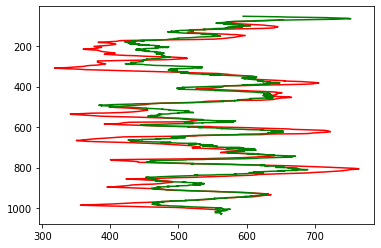

saving image
Saving Data to csv file
MSE for 20101109084810_02_25ppm_test_s.png is 0.006115216213098369
red is hand picked, green is found by model


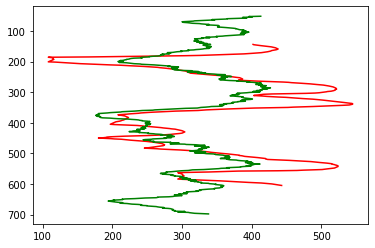

saving image
Saving Data to csv file
MSE for 20101110094203_05_25ppm_test_s.png is 0.02093120357009246
red is hand picked, green is found by model


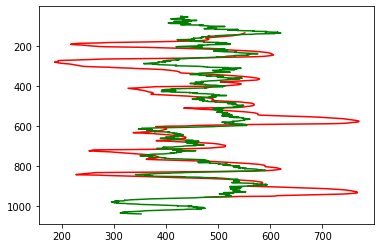

saving image
Saving Data to csv file
MSE for 20101111092821_01_25ppm_test_s.png is 0.023576993358807086
red is hand picked, green is found by model


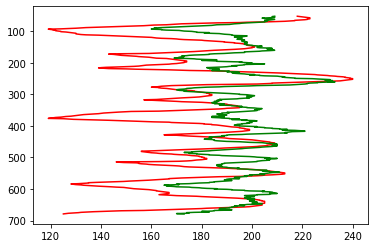

saving image
Saving Data to csv file
MSE for OneMile8_test_s.png is 0.015920307337878928
red is hand picked, green is found by model


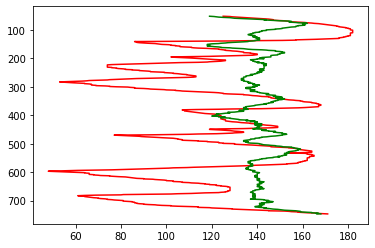

saving image
Saving Data to csv file
MSE for FC4_test_s.png is 0.03177222752646099

MSE summary for all timestacks:
20101109084810_02_25ppm_test_s.png 0.006115216213098369
20101110094203_05_25ppm_test_s.png 0.02093120357009246
20101111092821_01_25ppm_test_s.png 0.023576993358807086
OneMile8_test_s.png                0.015920307337878928
FC4_test_s.png                     0.03177222752646099

Average MSE for all seen timestacks = 0.019663189601267568
done


In [9]:
"""%%%%%%%%%%%%%%%%%%%% MACHINE LEARNING %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"""
# Every time you train a model, change the name below. 
# It is also good practice to record all hyperparameters you used and the performance 
# of each model trained. Then you can look through all your results and learn something.
tf_model_version = "test_0"

model = Sequential()
model.add(Conv2D(32, (3,3), input_shape = x_train.shape[1:]))
model.add(Activation("relu"))
model.add(Conv2D(32, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="SAME"))

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="SAME"))

model.add(Flatten())
model.add(Dense(512))
model.add(Dense(256))

model.add(Dense(1))
model.add(Activation('linear'))

# This line is if you want to use the GPU. The model.compile and model.fit lines need to be in the with statement.
#with tf.device('/gpu:0'):


# accuracy metric is not useful, but without it the evaluate section doesn't work
model.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, validation_split=0.1, epochs=10)

model.summary() # should always check this to make sure your architecture is a good size. If your sizes reduce to 1x1 too early, deeper layers are not very effective!

"""%%%%%%%%%%%%%%%%%%%% EVALUATION %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"""

# validation loss and validation accuracy should be close to training loss and accuracy (otherwise overfitting!)
train_loss, train_acc = model.evaluate(x_train, y_train)
val_loss, val_acc = model.evaluate(x_test, y_test)

print("training loss = " + str(train_loss) + ", training accuracy = " + str(train_acc))
print("test loss     = " + str(val_loss) + ", test accuracy     = " + str(val_acc))

model.save(tf_model_version + ".model")

predictions = model.predict([x_test])

# plot graphs inside the notebook
%matplotlib inline 

# make a new directory for results
current_path = os.getcwd()
results_dir = tf_model_version
results_dir_path = os.path.join(current_path, results_dir)
if os.path.exists(results_dir_path):
    shutil.rmtree(results_dir_path)
    print("old results directory removed")
os.mkdir(results_dir_path)
print("new results directory created called " + results_dir)

# don't change the min_uprush and max_uprush values, 
# these are fixed values according to the labelled evaluation timestacks
error_list = []
timestack_name = "20101109084810_02_25ppm_test_s.png" # 194 and 925
min_uprush = 194
max_uprush = 925
ground_truth_error = compare_shoreline(min_uprush, max_uprush, tf_model_version, IMG_SIZE, timestack_name, results_dir)
print("MSE for " + timestack_name + " is " + str(ground_truth_error))
error_list.append(ground_truth_error)

timestack_name = "20101110094203_05_25ppm_test_s.png" # 40 and 580
min_uprush = 40
max_uprush = 580
ground_truth_error = compare_shoreline(min_uprush, max_uprush, tf_model_version, IMG_SIZE, timestack_name, results_dir)
print("MSE for " + timestack_name + " is " + str(ground_truth_error))
error_list.append(ground_truth_error)

timestack_name = "20101111092821_01_25ppm_test_s.png" # 116 and 800
min_uprush = 116
max_uprush = 800
ground_truth_error = compare_shoreline(min_uprush, max_uprush, tf_model_version, IMG_SIZE, timestack_name, results_dir)
print("MSE for " + timestack_name + " is " + str(ground_truth_error))
error_list.append(ground_truth_error)

timestack_name = "OneMile8_test_s.png" # 77 and 289
min_uprush = 77
max_uprush = 289
ground_truth_error = compare_shoreline(min_uprush, max_uprush, tf_model_version, IMG_SIZE, timestack_name, results_dir)
print("MSE for " + timestack_name + " is " + str(ground_truth_error))
error_list.append(ground_truth_error)

timestack_name = "FC4_test_s.png" # 37 and 240
min_uprush = 37
max_uprush = 240
ground_truth_error = compare_shoreline(min_uprush, max_uprush, tf_model_version, IMG_SIZE, timestack_name, results_dir)
print("MSE for " + timestack_name + " is " + str(ground_truth_error))
error_list.append(ground_truth_error)

print("\nMSE summary for all timestacks:")
print("20101109084810_02_25ppm_test_s.png" + " " + str(error_list[0]))
print("20101110094203_05_25ppm_test_s.png" + " " + str(error_list[1]))
print("20101111092821_01_25ppm_test_s.png" + " " + str(error_list[2]))
print("OneMile8_test_s.png               " + " " + str(error_list[3]))
print("FC4_test_s.png                    " + " " + str(error_list[4]))

print("\nAverage MSE for all seen timestacks = " + str(np.mean(error_list)))

print("done")

You can now visualize your results in the results directory. You can run the below cell to see what my best results were.

old results directory removed
new results directory created called MThompson_best
red is hand picked, green is found by model


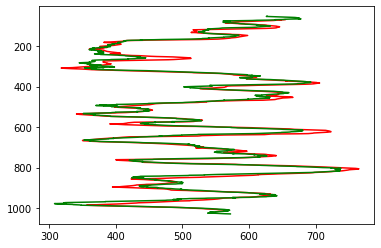

saving image
Saving Data to csv file
MSE for 20101109084810_02_25ppm_test_s.png is 0.001959924476879545
red is hand picked, green is found by model


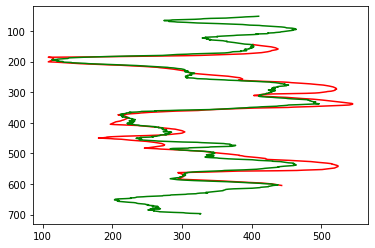

saving image
Saving Data to csv file
MSE for 20101110094203_05_25ppm_test_s.png is 0.006536662925551814
red is hand picked, green is found by model


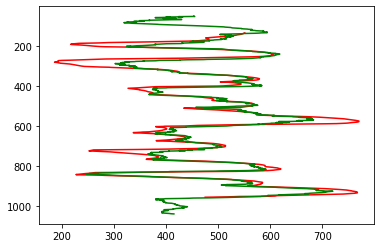

saving image
Saving Data to csv file
MSE for 20101111092821_01_25ppm_test_s.png is 0.007498531443070663
red is hand picked, green is found by model


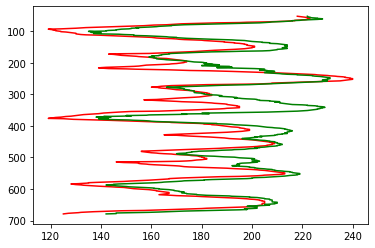

saving image
Saving Data to csv file
MSE for OneMile8_test_s.png is 0.008983188987626215
red is hand picked, green is found by model


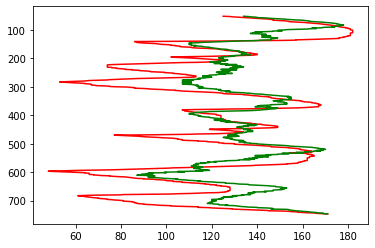

saving image
Saving Data to csv file
MSE for FC4_test_s.png is 0.01593063729243389

MSE summary for all timestacks:
20101109084810_02_25ppm_test_s.png 0.001959924476879545
20101110094203_05_25ppm_test_s.png 0.006536662925551814
20101111092821_01_25ppm_test_s.png 0.007498531443070663
OneMile8_test_s.png                0.008983188987626215
FC4_test_s.png                     0.01593063729243389

Average MSE for all seen timestacks = 0.008181789025112426
done


In [10]:
mt_model = "MThompson_best"

# make a new directory
current_path = os.getcwd()
results_dir = mt_model
results_dir_path = os.path.join(current_path, results_dir)
if os.path.exists(results_dir_path):
    shutil.rmtree(results_dir_path)
    print("old results directory removed")
os.mkdir(results_dir_path)
print("new results directory created called " + results_dir)

# don't change the min_uprush and max_uprush values, 
# these are fixed values according to the labelled evaluation timestacks
error_list = []
timestack_name = "20101109084810_02_25ppm_test_s.png" # 194 and 925
min_uprush = 194
max_uprush = 925
ground_truth_error = compare_shoreline(min_uprush, max_uprush, mt_model, IMG_SIZE, timestack_name, results_dir)
print("MSE for " + timestack_name + " is " + str(ground_truth_error))
error_list.append(ground_truth_error)

timestack_name = "20101110094203_05_25ppm_test_s.png" # 40 and 580
min_uprush = 40
max_uprush = 580
ground_truth_error = compare_shoreline(min_uprush, max_uprush, mt_model, IMG_SIZE, timestack_name, results_dir)
print("MSE for " + timestack_name + " is " + str(ground_truth_error))
error_list.append(ground_truth_error)

timestack_name = "20101111092821_01_25ppm_test_s.png" # 116 and 800
min_uprush = 116
max_uprush = 800
ground_truth_error = compare_shoreline(min_uprush, max_uprush, mt_model, IMG_SIZE, timestack_name, results_dir)
print("MSE for " + timestack_name + " is " + str(ground_truth_error))
error_list.append(ground_truth_error)

timestack_name = "OneMile8_test_s.png" # 77 and 289
min_uprush = 77
max_uprush = 289
ground_truth_error = compare_shoreline(min_uprush, max_uprush, mt_model, IMG_SIZE, timestack_name, results_dir)
print("MSE for " + timestack_name + " is " + str(ground_truth_error))
error_list.append(ground_truth_error)

timestack_name = "FC4_test_s.png" # 37 and 240
min_uprush = 37
max_uprush = 240
ground_truth_error = compare_shoreline(min_uprush, max_uprush, mt_model, IMG_SIZE, timestack_name, results_dir)
print("MSE for " + timestack_name + " is " + str(ground_truth_error))
error_list.append(ground_truth_error)

print("\nMSE summary for all timestacks:")
print("20101109084810_02_25ppm_test_s.png" + " " + str(error_list[0]))
print("20101110094203_05_25ppm_test_s.png" + " " + str(error_list[1]))
print("20101111092821_01_25ppm_test_s.png" + " " + str(error_list[2]))
print("OneMile8_test_s.png               " + " " + str(error_list[3]))
print("FC4_test_s.png                    " + " " + str(error_list[4]))

print("\nAverage MSE for all seen timestacks = " + str(np.mean(error_list)))

print("done")

If you want to use a GPU, this code is helpful to check that it will work. It can be a bit of a pain to set it up in anaconda, but the efficiency is worth it!

In [ ]:
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)